In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.0 MB/s eta 0:00:00


Загрузка необходимых библиотек

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

Подготовка данных.

Для данного проекта был выбран датасет diabetes. Это датасет для регрессионной задачи, содержащий медицинские данные о 442 пациентах с диабетом.
Целевая переменная (y): количественный показатель прогрессирования диабета через год после начала наблюдения

In [3]:
# Загрузка данных
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
print(f"Размер данных: {X.shape[0]} строк, {X.shape[1]} признаков")

# Диапазон целевой переменной
print(f"\nЦелевая переменная (y):")
print(f"   - Минимальное значение: {np.min(y)}")
print(f"   - Максимальное значение: {np.max(y)}")
print(f"   - Среднее значение: {np.mean(y):.1f}")
print(f"   - Стандартное отклонение: {np.std(y):.1f}")

# Признаки
print("\nХарактеристики признаков (X):")
print("   - Стандартизация (проверка среднего и дисперсии):")
for col in X.columns:
    print(f"     {col}: mean={X[col].mean():.2f}, var={X[col].var():.3f}")

# Проверка на пропуски
print("\nПроверка на пропущенные значения:")
print(f"   - В признаках: {X.isnull().sum().sum()} пропусков")
print(f"   - В целевой переменной: {pd.isnull(y).sum()} пропусков")

print("\nТипы данных:")
print(f"   - Признаки: {X.dtypes.unique()}")
print(f"   - Целевая переменная: {type(y[0])}")

# Примеры
print("\nПримеры значений (первые 5 строк):")
print(X.head())

Размер данных: 442 строк, 10 признаков

Целевая переменная (y):
   - Минимальное значение: 25.0
   - Максимальное значение: 346.0
   - Среднее значение: 152.1
   - Стандартное отклонение: 77.0

Характеристики признаков (X):
   - Стандартизация (проверка среднего и дисперсии):
     age: mean=-0.00, var=0.002
     sex: mean=0.00, var=0.002
     bmi: mean=-0.00, var=0.002
     bp: mean=-0.00, var=0.002
     s1: mean=-0.00, var=0.002
     s2: mean=0.00, var=0.002
     s3: mean=-0.00, var=0.002
     s4: mean=-0.00, var=0.002
     s5: mean=0.00, var=0.002
     s6: mean=0.00, var=0.002

Проверка на пропущенные значения:
   - В признаках: 0 пропусков
   - В целевой переменной: 0 пропусков

Типы данных:
   - Признаки: [dtype('float64')]
   - Целевая переменная: <class 'numpy.float64'>

6. Примеры значений (первые 5 строк):
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0

Признаки (X): 10 числовых медицинских показателей, предварительно стандартизированных (среднее = 0, дисперсия = 0.02).


age — возраст,

bmi — индекс массы тела,

bp — среднее артериальное давление,

s1-s6 — результаты анализов крови (например, уровень глюкозы, холестерина).

Особенности данных:

Небольшой объем (442 строки) — требует аккуратного обращения с переобучением.

Все признаки числовые, пропусков нет.

Целевая переменная имеет значительный разброс (высокая дисперсия).

Выбор моделей:

От данных можно ожидать высокой скоррелиированности признаков, например ИМТ и давление или параметры крови.

ElasticNet (линейная модель):

Комбинация L1- и L2-регуляризации помогает отбирать значимые признаки и бороться с мультиколлинеарностью. Из приемуществ также можно отметить интерпретируемость и устойчивость к шуму. К сложностям следует отнести то, что метод лучше работает с предполагаемой линейностью, что может быть неприменимо для сложных данных.

CatBoost (градиентный бустинг):

Автоматически обрабатывает нелинейные зависимости и взаимодействия признаков. Высокая точность, устойчивость к переобучению благодаря бустингу (полезно с небольшим размером датасета).

Однако, результаты сложнее интерпретировать, чем у линейных моделей.

Если какие то признаки сильно коррелируют, ElasticNet выберет один из них или усреднит вклад, а CatBoost построит дерева, учитывающие их совместное влияние.

Обучение моделей

In [4]:
# Инициализация моделей
elastic = ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=112)
catboost = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=5, silent=True, random_state=112)

# Обучение и оценка без Монте-Карло
elastic.fit(X_train_scaled, y_train)
catboost.fit(X_train_scaled, y_train)

elastic_pred = elastic.predict(X_test_scaled)
catboost_pred = catboost.predict(X_test_scaled)

print("ElasticNet:")
print(f"MSE: {mean_squared_error(y_test, elastic_pred):.2f}")
print(f"R²: {r2_score(y_test, elastic_pred):.2f}\n")

print("CatBoost:")
print(f"MSE: {mean_squared_error(y_test, catboost_pred):.2f}")
print(f"R²: {r2_score(y_test, catboost_pred):.2f}")

ElasticNet:
MSE: 2860.95
R²: 0.46

CatBoost:
MSE: 2660.00
R²: 0.50


Метод Монте-Карло (100 симуляций)

In [5]:
n_simulations = 100
test_size = X_test_scaled.shape[0]

# Массивы для хранения предсказаний
elastic_preds_mc = np.zeros((n_simulations, test_size))
catboost_preds_mc = np.zeros((n_simulations, test_size))

for i in range(n_simulations):
    # Bootstrap выборка
    indices = np.random.choice(len(X_train_scaled), len(X_train_scaled), replace=True)
    X_boot = X_train_scaled[indices]
    y_boot = y_train[indices]

    # Обучение и предсказание
    elastic.fit(X_boot, y_boot)
    elastic_preds_mc[i] = elastic.predict(X_test_scaled)

    catboost.fit(X_boot, y_boot)
    catboost_preds_mc[i] = catboost.predict(X_test_scaled)

# Расчет средних и доверительных интервалов
elastic_mean = elastic_preds_mc.mean(axis=0)
elastic_std = elastic_preds_mc.std(axis=0)

catboost_mean = catboost_preds_mc.mean(axis=0)
catboost_std = catboost_preds_mc.std(axis=0)

In [6]:
# Метрики после Монте-Карло
print("\nПосле Монте-Карло:")
print("ElasticNet:")
print(f"MSE: {mean_squared_error(y_test, elastic_mean):.2f}")
print(f"R²: {r2_score(y_test, elastic_mean):.2f}\n")

print("CatBoost:")
print(f"MSE: {mean_squared_error(y_test, catboost_mean):.2f}")
print(f"R²: {r2_score(y_test, catboost_mean):.2f}")


После Монте-Карло:
ElasticNet:
MSE: 2873.67
R²: 0.46

CatBoost:
MSE: 2656.02
R²: 0.50


Визуализация результатов

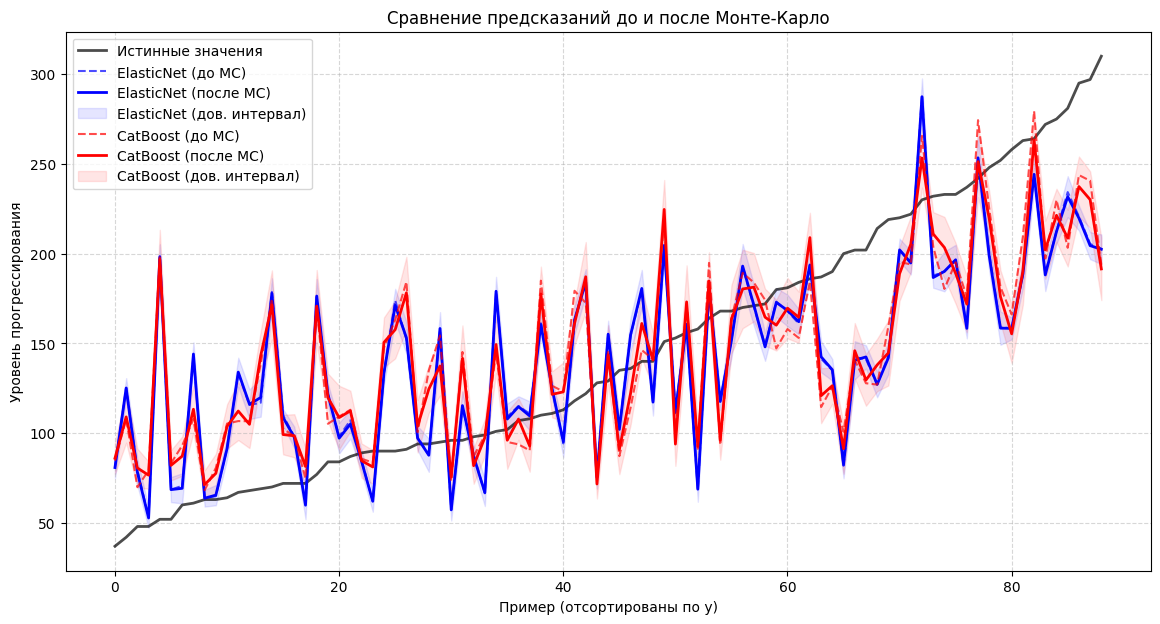

In [10]:
plt.figure(figsize=(14, 7))

sorted_idx = np.argsort(y_test)
y_test_sorted = y_test[sorted_idx]
elastic_pred_sorted = elastic_pred[sorted_idx]
catboost_pred_sorted = catboost_pred[sorted_idx]
elastic_mean_sorted = elastic_mean[sorted_idx]
catboost_mean_sorted = catboost_mean[sorted_idx]
elastic_std_sorted = elastic_std[sorted_idx]
catboost_std_sorted = catboost_std[sorted_idx]

# Истинные значения
plt.plot(y_test_sorted, label='Истинные значения', color='black', linewidth=2, alpha=0.7)

# ElasticNet: до и после Монте-Карло
plt.plot(elastic_pred_sorted, label='ElasticNet (до MC)', linestyle='--', color='blue', alpha=0.7)
plt.plot(elastic_mean_sorted, label='ElasticNet (после MC)', color='blue', linewidth=2)
plt.fill_between(
    range(len(y_test_sorted)),
    elastic_mean_sorted - elastic_std_sorted,
    elastic_mean_sorted + elastic_std_sorted,
    color='blue',
    alpha=0.1,
    label='ElasticNet (дов. интервал)'
)

# CatBoost: до и после Монте-Карло
plt.plot(catboost_pred_sorted, label='CatBoost (до MC)', linestyle='--', color='red', alpha=0.7)
plt.plot(catboost_mean_sorted, label='CatBoost (после MC)', color='red', linewidth=2)
plt.fill_between(
    range(len(y_test_sorted)),
    catboost_mean_sorted - catboost_std_sorted,
    catboost_mean_sorted + catboost_std_sorted,
    color='red',
    alpha=0.1,
    label='CatBoost (дов. интервал)'
)

plt.xlabel('Пример (отсортированы по y)')
plt.ylabel('Уровень прогрессирования')
plt.title('Сравнение предсказаний до и после Монте-Карло')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

По оси абсцисс номера примеров из тестовой выборки, отсортированные по возрастанию истинных значений y_test. Сортировка сделана для лучшей наглядности.

По оси ординат значения целевой переменной, уровень прогрессирования диабета в исходных единицах.



Выводы: применеие метода Монте-Карло практически никак не повлияло на метрики методов. Сравнивая методы, CatBoost демонстрирует более высокую точность и стабильность по сравнению с ElasticNet. Особенно следует отметить лучшие доверительные интервалы.

Также Метод Монте-Карло незначительно улучшил CatBoost, но почти не повлиял на ElasticNet. Это может указывать на следущее:

ElasticNet менее чувствителен к вариациям данных из-за своей линейной природы.

CatBoost, как ансамблевая модель, лучше адаптируется к шуму, вероятно, при увеличении числа симуляций будет виден лучший эффект.

Учитывая природу данных (медицина), линейность метода может быть крайне полезна, поскольку напрямую обозначит связь признаков (медицинских показателей) с целевой переменной (динамикой болезни).

CatBoost показал себя лучше по статистическим показателям, но ElasticNet остается полезным для первичного анализа данных из-за природы линейности.